In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import deconvolve as dcvl

# set simulation parameters
TR = 1 # duration of TR
endBuffer = 16 # null period following sequence specified in par file
tau = 2 # determines shape of simulated hemodynamic response function (HRF)
noiseSD = 0.1 # SD of guassian noise added to simulated time series
nTimes = 20 # number of TRs to simulate the HRF across
nRuns = 3 # number of runs/scans to concatenate (between 1 and 10)

(0, 19)

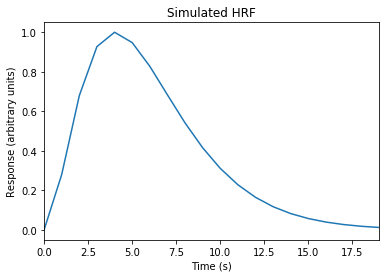

In [75]:
# make HRF
t = np.arange(0,nTimes,TR)
HRF = TR*(t/tau)**2 * np.exp(-t/tau) / 2*tau # REVIEW: still need to include the delta param...
HRF = HRF/np.max(HRF)

plt.plot(HRF)
plt.title('Simulated HRF')
plt.xlabel('Time (s)')
plt.ylabel('Response (arbitrary units)')
plt.xlim([0,nTimes-1])

Text(0.5, 1.0, 'Simulated time-series')

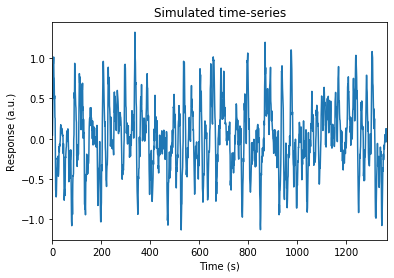

In [76]:
# simulate fMRI time-series

# load and concatenate paradigm files 
file_dir = os.getcwd() + '/example_paradigm_files/'
run_numbers = list(range(1,nRuns+1))
run_names = dcvl.create_parfile_list(run_numbers,'par')

stimTimes, cond, runNum, totalDur = dcvl.compile_paradigm_files(file_dir,run_names,endBuffer)

nRuns = len(np.unique(runNum))
nConds = len(np.unique(cond))
nTRs = int(totalDur/TR)

# generate design matrix
designMatrix, condIdx = dcvl.buildDesignMatrix_paramEst(cond,stimTimes,runNum,HRF)

# response amplitude (betas) for each condition
betas = np.linspace(-1,1,nConds)
betas = np.concatenate((betas,np.zeros(nRuns))) # add zeros for run terms in design matrix

# simulate fMRI time series by multiplying deisgn matrix by random betas and adding gaissina noise
fMRI = np.matmul(designMatrix,betas) + np.random.standard_normal(nTRs)*noiseSD

# plot simulated BOLD time series
plt.figure()
plt.plot(range(nTRs), fMRI)
plt.xlabel('Time (s)')
plt.xlim([0,nTRs])
plt.ylabel('Response (a.u.)')
plt.title('Simulated time-series')


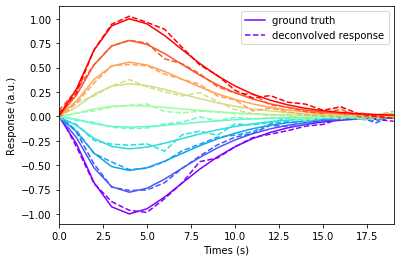

In [80]:
# perform deconvolution

# to estimate betas for each condition, solve the GLM (via least squares)
designMatrix_pinv = np.linalg.pinv(designMatrix) 
betas_est = np.dot(designMatrix_pinv,fMRI)
   
# build a design matrix for deconvolution
nTimes = 20  # number of time points to deconvolve
designMatrix, condIdx = dcvl.buildDesignMatrix_deconvolve(cond, stimTimes, runNum, nTimes)

# do deconvolution!
designMatrix_pinv = np.linalg.pinv(designMatrix) 
betas_est = np.dot(designMatrix_pinv,fMRI)

deconvolvedResp = np.zeros([nConds,nTimes])
for c in range(nConds):
   deconvolvedResp[c,:] = betas_est[condIdx == c+1]

plt.figure()
colors = pl.cm.rainbow(np.linspace(0,1,nConds))
for c in range(nConds):
    ground_truth = betas[c]*HRF
    plt.plot(range(nTimes),ground_truth,color=colors[c])
    plt.plot(range(nTimes),deconvolvedResp[c,:],color=colors[c],linestyle='--')
plt.xlim([0,nTimes-1])
plt.xlabel('Times (s)')
plt.ylabel('Response (a.u.)')
plt.legend(['ground truth','deconvolved response'])


(0, 1367)

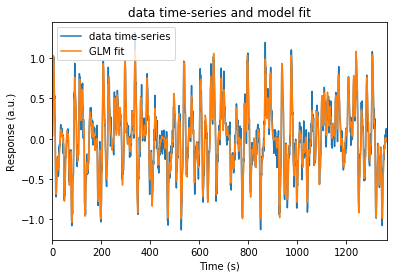

In [79]:
# calculate the predicted fMRI response given the estimated beta weights
pred = np.matmul(designMatrix,betas_est)

plt.figure()
plt.plot(range(nTRs), fMRI, label='data')
plt.plot(range(nTRs),pred, label='fit')
plt.xlabel('Time (s)')
plt.ylabel('Response (a.u.)')
plt.legend(['data time-series', 'GLM fit'])
plt.title('data time-series and model fit')
plt.xlim([0,nTRs-1])